In diesem Notebook wird der Datensatz base_fake_real.csv verwendet und untersucht wie man Fake-Reviews von Echten Reviews unterscheiden kann.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib
from fastai.vision.all import *
from fastdownload import download_url

## Text:

Über Sprach-Features aus PNLP

## Bild:
Erkennung, ob das Bild ein Fake ist oder nicht über eine Bildklassifizierung.

In [ ]:
df = pd.read_csv('base_keywords_sentiment_reduced.csv')
print(df.shape)

df_all = pd.read_csv('01_Data/raw_data/dataset_weitere_forschung.csv')
print(df_all.shape)

df_all = df_all[['text', 'reviewId', 'url', 'placeId', 'categoryName', 'stars', 'title','reviewImageUrls/0','reviewImageUrls/1','reviewImageUrls/2','reviewImageUrls/3','reviewImageUrls/4','reviewImageUrls/5','genre']]
df_all = df_all[df_all['reviewImageUrls/0'].notna()]
print(df_all.shape)
df_all = df_all[~df_all['reviewId'].isin(df['reviewId'])]
print(df_all.shape)
print(df_all.columns)

image_urls_cols = [
    "reviewImageUrls/0",
    "reviewImageUrls/1",
    "reviewImageUrls/2",
    "reviewImageUrls/3",
    "reviewImageUrls/4",
    "reviewImageUrls/5",
]
for col in image_urls_cols:
    print(f"Processing col {col}")
    df_all[col] = df_all[col].str.replace("=w150-h150-k-no-p", "=w256-h256-p-k-no")

print(df_all.shape)

# df_all.to_csv('train_weitere_forschung_ohne_base.csv', index=False)
# df_all.to_excel('train_weitere_forschung_ohne_base.xlsx', index=False)

In [ ]:
df = pd.read_csv('train_weitere_forschung_ohne_base.csv')

df = df.sample(n=500, random_state=9)
# df = df.sample(n=1000, random_state=42)
df = df.sort_index()

for index, row in df.iterrows():
    if index < 0:
        print(f"Index {index} schon heruntergeladen, skipped ..")
        continue
    for i in range(2):
        if not pd.isna(row[f'reviewImageUrls/{i}']):
            print(f"Downloading image for {index}...")
            url = row[f'reviewImageUrls/{i}']
            filename = f"{url.split('/')[-1]}.png"
            path = os.path.join('02_Images', 'train', 'real', filename)
            if not os.path.exists(path):
                try:
                    urllib.request.urlretrieve(url, path)
                except:
                    print(f'Error with {url}')

print("Done with downloading real images for training set.")

In [ ]:
# dwonlad for every row the file of column 

# f

### Start Umsetzung mit FASTAI visual Learning als Classifizierung Problem (AUF COLAB!)

In [ ]:
path = Path('02_Images/train')
fns = get_image_files(path)
fns

In [ ]:
failed = verify_images(fns)
print(failed)
if len(failed) > 0:
    failed.map(Path.unlink);
else:
    print("All images verified successfully.")

In [ ]:
classes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

print("Done with creating DataBlock.")

In [ ]:
dls = classes.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)
print(len(dls.valid.items))

In [ ]:
classes = classes.new(item_tfms=Resize(256, ResizeMethod.Squish))
dls = classes.dataloaders(path)

classes = classes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = classes.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs = 4, freeze_epochs=1)

Auswertung des Image-Klassifikators

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.savefig('image_classificator_confusion_matrix.svg', format='svg', dpi=1200)

In [ ]:
print("Die Bilder mit den schlechtesten loss Werte.")
interp.plot_top_losses(25, nrows=10)

## Anwendung des Image Classificators auf die url0 (Auf COLAB)
(Hier nur die Auswertung)

Accuracy: 0.95
F1-Score: 0.95
Recall: 0.95
Precision: 0.95


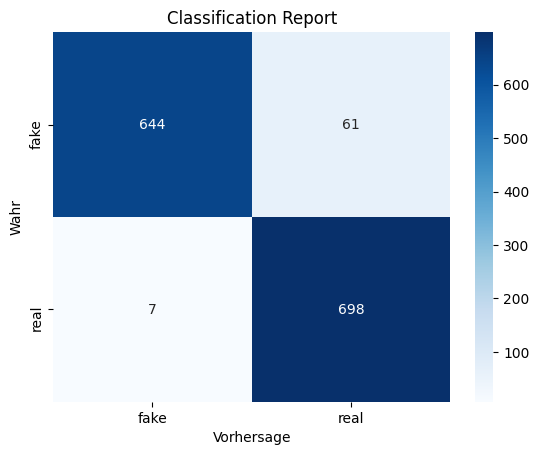

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load data
df = pd.read_csv('base_fake_real_imgcls_pred.csv')

y_true = df['label']
y_pred = df['prediction_0']

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

recall = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['recall']
print(f'Recall: {recall:.2f}')

precision = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['precision']
print(f'Precision: {precision:.2f}')

f1_score = classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f'F1-Score: {f1_score:.2f}')





# Plot confusion matrix
labels = y_true.unique()
cm = confusion_matrix(y_true, y_pred, labels=labels)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Vorhersage')
plt.ylabel('Wahr')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.svg')

# Plot classification report
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.drop('support', axis=1, inplace=True)
#sns.heatmap(df_report[['precision', 'recall', 'f1-score']], annot=True, cmap='Blues')
plt.title('Classification Report')
plt.savefig('classification_report.svg')

In [9]:
df = pd.read_csv('base_fake_real_imgcls_pred.csv')
print(df.columns)
print(df.head())

Index(['index_fake', 'org_text', 'title', 'org_reviewId', 'categoryName',
       'reviewUrl', 'reviewerPhotoUrl', 'reviewerUrl', 'url', 'genre', 'label',
       'placeId', 'prompt_v2', 'gpt3_v2', 'prompt_v3', 'gpt3_v3', 'gpt3_v3.1',
       'prompt_v4', 'text', 'sent_v2', 'sent_v3', 'sent_v3.1', 'sent_v4',
       'reviewId', 'dalle_prompt', 'reviewImageUrls/0', 'publishedAtDate',
       'name', 'likesCount', 'reviewerNumberOfReviews', 'isLocalGuide',
       'org_stars', 'stars', 'reviewImageUrls/1', 'reviewImageUrls/2',
       'subTitle', 'description', 'price', 'totalScore', 'reviewImageUrls/3',
       'reviewerId', 'reviewsCount', 'state', 'street', 'temporarilyClosed',
       'website', 'keywords', 'keywords_only', 'sentiment', 'sent_score_0',
       'text_length', 'prediction_0', 'prediction_0_prob'],
      dtype='object')
   index_fake  \
0         0.0   
1         1.0   
2         2.0   
3         3.0   
4         4.0   

                                                           

## Tabulare Daten:



## Erst Text, dann Bildverifizierung